# Project: Investigate a Dataset (TMDb movie data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

- This data set contains information about 10,000+ movies collected from The Movie Database (TMDb), with data_columns like user ratings, revenue, budget etc. to name a few. I am fond of watching movies in my free time. Hence, I got curious in analyzing movies data and selected this data set for my porject.
- After having superficial look at the data, I have come up with following questions, for which i want to get answers from the dataset :
    1. Top 10 highest grossing movies by revenue (without adjusted for inflation).
    2. Top 10 highest grossing movies by revenue (with adjusted for inflation).
    3. Number of movies made in each genre.
    4. What kinds of properties are associated with movies that have high revenues? (I took this question directly from the example questions give in project details. Of course, I am interested in getting answer to this question)

- First, I have imported all necessary libraries which will be useful throughout the project.
- Also, I have included **%matplotlib inline** to utilize jupyter notebook's magic feature. This line of code will allow me to directly plot graphs in same notebook window as well as without using **plot.show()** function!

In [144]:
#importing all necessary libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#below line is used for showing matplotlib visualizations in same notebook window
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### Steps :

- For data cleaning, I am loading csv dataset into pandas dataframe. DataFrames have better functionalities as compared to numpy arrays, so i am going with DataFrames.
- Next, I am printing first few rows of dataset to have a superficial look at data as well as data types for each column.
- Then, I am printing datatypes of all the columns to make sure that respective columns have necessary datatypes.

In [145]:
#load data into movies dataframe
movies = pd.read_csv('tmdb-movies.csv')

#printing few rows of dataset
print movies.head()

#printing datatypes of each column in dataframe/table
print movies.dtypes    

       id    imdb_id  popularity     budget     revenue  \
0  135397  tt0369610   32.985763  150000000  1513528810   
1   76341  tt1392190   28.419936  150000000   378436354   
2  262500  tt2908446   13.112507  110000000   295238201   
3  140607  tt2488496   11.173104  200000000  2068178225   
4  168259  tt2820852    9.335014  190000000  1506249360   

                 original_title  \
0                Jurassic World   
1            Mad Max: Fury Road   
2                     Insurgent   
3  Star Wars: The Force Awakens   
4                     Furious 7   

                                                cast  \
0  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...   
1  Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...   
2  Shailene Woodley|Theo James|Kate Winslet|Ansel...   
3  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...   
4  Vin Diesel|Paul Walker|Jason Statham|Michelle ...   

                                            homepage          director  \
0                      

- As, We can see in the output, columns **revenue_adj** and **budget_adj** have values in scientific format and their data type is float64.
- But, I need **revenue_adj** and **budget_adj** column values to be in integer format for my analysis. So first, i am converting these column values from float format to integer format
- Lastly, printing their data types to confirm the conversion

In [146]:
#assigning integer data type to revenue_adj and budget_adj columns
movies[['revenue_adj', 'budget_adj']] = movies[['revenue_adj', 'budget_adj']].astype(int)

#print data types of revenue_adj and budget_adj to confirm 
print movies[['revenue_adj', 'budget_adj']].dtypes

revenue_adj    int64
budget_adj     int64
dtype: object


- Other thing, I noticed in output of dataset, is that, there are many unnecessary columns, *which I am neither going to use in analysis nor I am interested in knowing*.
- Thus, I am removing them from the dataset

In [147]:
#checking if 'movies' contains columns to prevent error while re-running this cell
if {'popularity','imdb_id', 'homepage', 'production_companies', 'tagline', 'keywords', 'overview', 
             'release_date'}.issubset(movies.columns):
    #removing unnecessary coulmns from the movies dataframe
    movies.drop(['popularity','imdb_id', 'homepage', 'production_companies', 'tagline', 'keywords', 'overview', 
             'release_date'], axis=1, inplace = True)

- Printing dataframe to confirm the output of previous operation

In [148]:
#print first 5 rows of dataframe
print movies.head(5)

       id     budget     revenue                original_title  \
0  135397  150000000  1513528810                Jurassic World   
1   76341  150000000   378436354            Mad Max: Fury Road   
2  262500  110000000   295238201                     Insurgent   
3  140607  200000000  2068178225  Star Wars: The Force Awakens   
4  168259  190000000  1506249360                     Furious 7   

                                                cast          director  \
0  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...   Colin Trevorrow   
1  Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...     George Miller   
2  Shailene Woodley|Theo James|Kate Winslet|Ansel...  Robert Schwentke   
3  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...       J.J. Abrams   
4  Vin Diesel|Paul Walker|Jason Statham|Michelle ...         James Wan   

   runtime                                     genres  vote_count  \
0      124  Action|Adventure|Science Fiction|Thriller        5562   
1      120  Action|A

- While having peripheral look at the original dataset file, I found out that, there are some records with revenue being 0 implying revenue for that perticular movie is not available! Hence, I won't be able to use them for movie revenues related analysis.
- Thus, I will simply filter out the records having non zero revenues. As, adjusted revenues for inflation depend on original revenues, those records, having '0' as revenue_adj value, will be removed too.

In [149]:
#removing all rows with movies, which have revenue = 0$
movies_with_non_zero_revenue = movies[movies.revenue != 0] 

#printing lowest revenue value to confirm only records with non-zero revenues are reamining.
print movies_with_non_zero_revenue['revenue'].min()

2


<a id='eda'></a>
## Exploratory Data Analysis


- For exploring data, first i am defining all helper functions, those can be used multiple times throughout the project

### Helper Functions

<a id='svbc'></a>
### sort_values_by_column

In [150]:
#This function is used to sort the values of dataframe by its column values, in ascending or descending order
def sort_values_by_column(movies_df, col_name,  order, num):
    
    #checking if sort in ascending order or descending order
    if order == 'asc': 
        
        #dataframe.sort_values() function will sort the dataframe rows according to specified column
        sorted_movies = movies_df.sort_values(by=[col_name], ascending=True).head(num)        
    elif order == 'desc':
        sorted_movies = movies_df.sort_values(by=[col_name], ascending=False).head(num)
        
    #assigning custom index to the dataframe
    sorted_movies.index = range(num)
    return sorted_movies

<a id='tmpc'></a>
### top50_movies_properties_chart

In [151]:
#This function is used for plotting properties of high revenu movies
def top50_movies_properties_chart(x_col, x_label, p_title):

    all_movies = plt.scatter(movies_with_non_zero_revenue[x_col],
                             movies_with_non_zero_revenue['revenue'],
                             marker='o', color='c')
    hr_movies = plt.scatter(top50_movies_by_revenue[x_col],
                            top50_movies_by_revenue['revenue'],
                     marker='o', color='m')

    plt.title(p_title)
    plt.xlabel(x_label)
    plt.ylabel('Revenue in $')
    plt.legend((all_movies, hr_movies),
               ('All movies data', 'High revenue movies data'),
               scatterpoints=1,
               loc='upper right',
               ncol=2,
               fontsize=8)
    plt.ticklabel_format(style='plain')

<a id='pma'></a>
### plot_movies_attrs

In [152]:
#This function is used for plotting movies' attributes like revenue, adjusted revenue and genres
def plot_movies_attrs(movies_df, rev_col, xticks, x_label, y_label, p_title):
    x = np.array(range(len(movies_df)))
    y = np.array(movies_df[rev_col].tolist())
    sns.barplot(range(len(movies_df)), y, palette="Blues_d")
    plt.title(p_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(x, xticks, rotation=90)
    plt.ticklabel_format(style='plain', axis='y')

<a id='egw'></a>
### extract_genres_with_moviesInIt

In [153]:
#This function is used for getting genres with number of movies in each genre
def extract_genres_with_moviesInIt(s_genres):   
    
    #applying extract_genre() function over all values of s_genre series
    s_genres.apply(extract_genre)
    df = pd.DataFrame(genre_count, index = [0])
    
    #this will convert rows->columns (or vice versa)
    df = df.transpose()
    return df


<a id='eg'></a>
### extract_genre

In [154]:
# This function is used to extract genres from each cell of the table 
# and create dictonary with genre-genre_count pair
def extract_genre(s):
    
    #checking if 's' is the string instance or not and to prevent error from 'nan' instances
    if isinstance(s, str):        
        list_genres = s.split("|")    
        for g in list_genres:
            if genre_count.has_key(g):
                temp_dict = {g:genre_count.get(g)+1}
                genre_count.update(temp_dict)
            else:
                genre_count.update(({g:1}))     


### Research Question 1

#### Which are the top 10 highest grossing movies by revenue without adjusted for inflation?

- I want to know the details like, movie name, director, cast, budget etc. about the top 10 highest grossing movies without adjusted for inflation.
- To get the answer, I will simply use helper function <a href="#svbc">sort_values_by_column</a>, which will output the movies in descending order of their revenue.

In [155]:
#Using helper function sort_values_by_column() to get the data of top 10 highest grossing movies
top10_movies_df = sort_values_by_column(movies_with_non_zero_revenue, 'revenue', 'desc', 10)

#print the filtered dataframe
print top10_movies_df

       id     budget     revenue  \
0   19995  237000000  2781505847   
1  140607  200000000  2068178225   
2     597  200000000  1845034188   
3   24428  220000000  1519557910   
4  135397  150000000  1513528810   
5  168259  190000000  1506249360   
6   99861  280000000  1405035767   
7   12445  125000000  1327817822   
8  109445  150000000  1274219009   
9   68721  200000000  1215439994   

                                 original_title  \
0                                        Avatar   
1                  Star Wars: The Force Awakens   
2                                       Titanic   
3                                  The Avengers   
4                                Jurassic World   
5                                     Furious 7   
6                       Avengers: Age of Ultron   
7  Harry Potter and the Deathly Hallows: Part 2   
8                                        Frozen   
9                                    Iron Man 3   

                                         

#### Plots for checking the trend for top 10 movies

- To get the direct view of top 10 highest grossing movie names and their revenue, I have plotted *movies->revenues* chart below. For this, first i am extracting movie names from top10_movies_df.
- Then, I will simply use helper function <a href="#pma">plot_movies_attrs</a> for plotting.

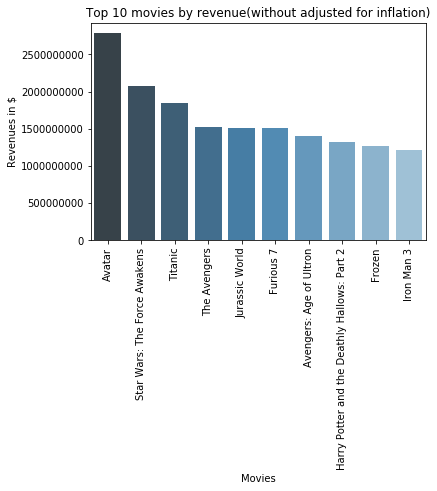

In [156]:
#extracting movie names from top10 movies dataframe
movie_names = top10_movies_df['original_title'].tolist()

#Using helper function plot_movies_attrs() to plot the graph of movie -> revenue
plot_movies_attrs(top10_movies_df, 'revenue', movie_names, 'Movies', 'Revenues in $',
                  'Top 10 movies by revenue(without adjusted for inflation)')

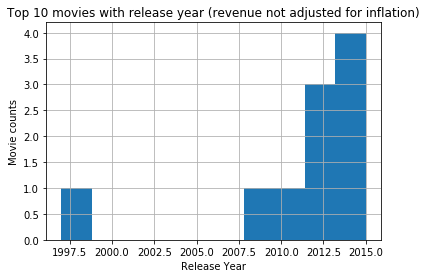

In [157]:
#plotting histogram for top10 movies with their release year
plt.title('Top 10 movies with release year (revenue not adjusted for inflation)')
plt.xlabel('Release Year')
plt.ylabel('Movie counts')
top10_movies_df['release_year'].hist()

### Observations

- Here, we get the details of top 10 highest grossing movies.
- From the bar chart we can notice that, all 10 movies have revenue above $1 bilion
- From the above histogram, we can see that except for 1 movie(which released in 1997), all 9 movies have been released recently just after 2008. And that can be one of the reasons for these movies to be in top 10. As years pass, movie ticket prices are going up too. So, recently released(during last decade) movies have higher chances of getting more revenue then movies, which released couple of decades ago.

### Research Question 2

#### Which are the top 10 highest grossing movies by revenue with adjusted for inflation?

- This question is similar to the first question except, here i want to know about top movies with revenues adjusted for inflation. 
- As, we saw in previous question, most of movies from top 10 were released just after 2008. But, If we compare movie ticket prices in 2008 with prices couple of decades ago, we can see that prices were way higher after 2008. So, this might have affected the outcome of *top 10 movies just by their original revenues*. Hence, I am interested in finding *top 10 higest grossing movies by adjusted revenues for inflation*.


- If you look at the function <a href="#svbc">sort_values_by_column</a>, It is implemented in a way, so that, I can just change the argument **col_name** to **revenue_adj** for finding answer to this question.
- And by outputting the filtered dataframe , i got all datapoints,in which i am interested.

In [158]:
#Using helper function sort_values_by_column() to get dataframe of 'top 10 movies by adjusted revenue'
top10_movies_df_adj = sort_values_by_column(movies_with_non_zero_revenue, 'revenue_adj', 'desc', 10)

#printing filtered dataframe
print top10_movies_df_adj

       id     budget     revenue                  original_title  \
0   19995  237000000  2781505847                          Avatar   
1      11   11000000   775398007                       Star Wars   
2     597  200000000  1845034188                         Titanic   
3    9552    8000000   441306145                    The Exorcist   
4     578    7000000   470654000                            Jaws   
5  140607  200000000  2068178225    Star Wars: The Force Awakens   
6     601   10500000   792910554      E.T. the Extra-Terrestrial   
7    1642   22000000  1106279658                         The Net   
8   12230    4000000   215880014  One Hundred and One Dalmatians   
9   24428  220000000  1519557910                    The Avengers   

                                                cast  \
0  Sam Worthington|Zoe Saldana|Sigourney Weaver|S...   
1  Mark Hamill|Harrison Ford|Carrie Fisher|Peter ...   
2  Kate Winslet|Leonardo DiCaprio|Frances Fisher|...   
3  Linda Blair|Max von Sydo

#### Plots for better understanding of trends

- Similar to question 1, I am plotting chart for *movies->adjusted revenue for inflation* , using <a href="#pma">plot_movies_attrs</a> function for visualization.

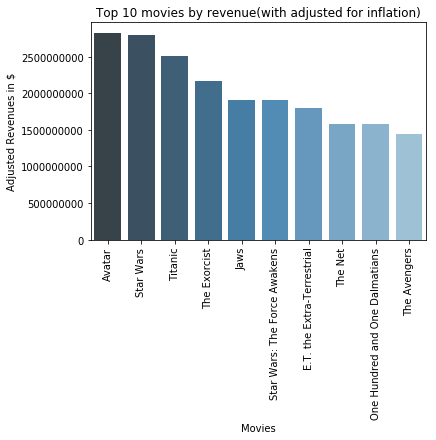

In [159]:
#Extracting movie names from top10 movies dataframe
movie_names = top10_movies_df_adj['original_title'].tolist()

#Plotting movie->adjusted revenue graph by using helper function plot_movies_attrs()
plot_movies_attrs(top10_movies_df_adj, 'revenue_adj', movie_names, 'Movies', 'Adjusted Revenues in $',
                 'Top 10 movies by revenue(with adjusted for inflation)')

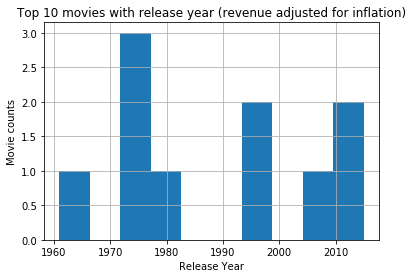

In [160]:
#plotting histogram for top10 movies with their release year
plt.title('Top 10 movies with release year (revenue adjusted for inflation)')
plt.xlabel('Release Year')
plt.ylabel('Movie counts')
top10_movies_df_adj['release_year'].hist()

### Observations 

- Here, we have the data for top 10 highest grossing movies by revenues adjusted for inflation.
- If we compare outcome of this question to question 1's outcome, We can see that, only 4 movies from previous *top 10 movies list*, made it to this *top 10 movies list* : 
    - Avatar, Star Wars: The Force Awakens, Titanic, The Avengers
- From the above bar chart, we can notice that, all 10 movies have *adjusted revenues* almost above $1.5 billion.
- By looking at histogram, we can observe that movies ,in this list, span from year 1961 to 2015, which is quite astonishing(For me atleast)!
  

### Research Question 3

#### How many movies were made in each genre?

- By this question, i intend to find the number of movies made in each genre for the given dataset. When you look at column 'genres' in dataset, you can notice that, each movie falls within multiple genres. 
- For example, **Jurassic Park** movie has genre data something like - *"Action|Adventure|Science Fiction|Thriller"*, which implies jurassic park movie falls in Action, Adventure, Science, Fiction and Thriller genres. So, while counting number of movies for each genre, we will get total genres count greater than total movies. 


- I am using helper function <a href="#egw">extract_genres_with_moviesInIt</a> to get the count of movies for each genre.
- By printing the resultant dataframe, we can get the required values.

In [161]:
# initializing empty dictionary
genre_count = dict()

#using helper function extract_genres_with_moviesInIt() to convert genre dictionary to dataframe
genres_with_genre_count_df = extract_genres_with_moviesInIt(movies['genres'])

#print the dataframe
print genres_with_genre_count_df

#printing sum of number movies in each genre
print "\nSum of Number of movies in each genre : {}".format(genres_with_genre_count_df[0].sum())

                    0
Action           2385
Adventure        1471
Animation         699
Comedy           3793
Crime            1355
Documentary       520
Drama            4761
Family           1231
Fantasy           916
Foreign           188
History           334
Horror           1637
Music             408
Mystery           810
Romance          1712
Science Fiction  1230
TV Movie          167
Thriller         2908
War               270
Western           165

Sum of Number of movies in each genre : 26960


#### Visualization of genres with movies_count

- I have plotted *genre->no. of movies in it* graph for better understanding of trend.
- I am using function <a href="#pma">plot_movies_attrs</a> for visualizing trend.

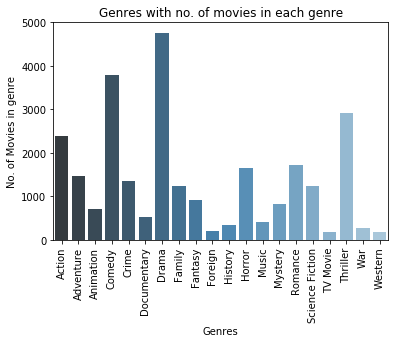

In [162]:
#extracting genre names from genre dataframe
genre_names = genres_with_genre_count_df.index.values.tolist() 

#plotting genre->no. of movie in it graph using helper function plot_movies_attrs()
plot_movies_attrs(genres_with_genre_count_df, 0, genre_names, 'Genres', 'No. of Movies in genre',
                 'Genres with no. of movies in each genre')

### Observations

- We have the number of movies for each genre.
- We can notice from outcome that, the sum of *number of movies in each genre* is 26960, which is way higher than the total movies=10,866 in dataset. As i explained earlier, single movie might be in multiple genres, that's why we are getting this result.
- From the graph, we can observe that, genres **'Drama', 'Comedy' and 'Thriller'** are most popular among directors.

### Research Question 4

#### What kinds of properties are associated with movies that have high revenues?

- To find the properties associated with movies having high revenues, first i need to find the movies with high revenues. Then, i can compare them with all movies to find distinctive properties.

- Important considerations/assumptions for this analysis :
    - Here, I am considering sample of top 50 movies to find the properties of high revenue movies.
    - I am not considering *top movies by revenues adjusted for inflation*. I am only taking into account *top movies by their original revenues*.

- I hava already defined the funtion <a href="#svbc">sort_values_by_column</a>, which returns the movies in descending order of their revenue. One of the arguments of this function is *num*. If you pass num=10, then this function will return top 10 movies in order. Likewise, If i pass num=50, it will return top 50 movies by revenue in descending order. 

In [163]:
#using helper function sort_values_by_column() to extract 'top50 movies by revenue' from the dataframe
top50_movies_by_revenue = sort_values_by_column(movies_with_non_zero_revenue, 'revenue', 'desc', 50)

#### Investigating possible properties of high revenue movies

In [164]:
#printing few rows of top50_movies_by_revenue
print top50_movies_by_revenue.head()

       id     budget     revenue                original_title  \
0   19995  237000000  2781505847                        Avatar   
1  140607  200000000  2068178225  Star Wars: The Force Awakens   
2     597  200000000  1845034188                       Titanic   
3   24428  220000000  1519557910                  The Avengers   
4  135397  150000000  1513528810                Jurassic World   

                                                cast         director  \
0  Sam Worthington|Zoe Saldana|Sigourney Weaver|S...    James Cameron   
1  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...      J.J. Abrams   
2  Kate Winslet|Leonardo DiCaprio|Frances Fisher|...    James Cameron   
3  Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...      Joss Whedon   
4  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...  Colin Trevorrow   

   runtime                                     genres  vote_count  \
0      162   Action|Adventure|Fantasy|Science Fiction        8458   
1      136   Action|Advent

- From above output, I have decided to consider features **budget, vote_count, vote_average, release_year and runtime**, as they have numerical values. So, i will be able to find descriptive statistics easily for them and will be able to compare them to find relevant properties. 

- Also, I have noticed that **genres** column has some genres in common for multiple movies. Thus, i will consider investigating **genres** column too.

#### Analysis of numerical features
- Now, i will find descriptive statistics for top 50 movies.
- In pandas, we can use describe() function on dataframe to find descriptive statistics.

In [165]:
#find descriptive statistics for top50 movies
top50_movies_stats = top50_movies_by_revenue[['budget', 'vote_count', 'vote_average', 'runtime', 'release_year']] \
                     .describe()
#print stats    
print top50_movies_stats     

             budget   vote_count  vote_average     runtime  release_year
count  5.000000e+01    50.000000     50.000000   50.000000     50.000000
mean   1.689400e+08  3986.920000      7.006000  138.120000   2008.160000
std    7.289618e+07  2037.739252      0.617569   26.960773      5.860139
min    2.200000e+07   201.000000      5.600000   88.000000   1993.000000
25%    1.135000e+08  2863.000000      6.500000  121.750000   2004.250000
50%    1.550000e+08  3375.500000      7.150000  142.000000   2010.000000
75%    2.150000e+08  4999.000000      7.400000  152.750000   2012.750000
max    3.800000e+08  9767.000000      8.100000  201.000000   2015.000000


- From the output, it is visible that 'budget' column has scientific values and other columns have values upto 6 decimal points. So, i need to fix this first by rounding these values.

In [166]:
#rounding values of budget coulmn
top50_movies_stats['budget'] = top50_movies_stats['budget'].round()

#print dataframe
print top50_movies_stats.round(3)

            budget  vote_count  vote_average  runtime  release_year
count         50.0      50.000        50.000   50.000         50.00
mean   168940000.0    3986.920         7.006  138.120       2008.16
std     72896183.0    2037.739         0.618   26.961          5.86
min     22000000.0     201.000         5.600   88.000       1993.00
25%    113500000.0    2863.000         6.500  121.750       2004.25
50%    155000000.0    3375.500         7.150  142.000       2010.00
75%    215000000.0    4999.000         7.400  152.750       2012.75
max    380000000.0    9767.000         8.100  201.000       2015.00


#### Comparing *high revenue movies* with *all movies*  by plots

- I have plotted 5 grahs comparing *all movies' data* with *high revenue movies' data* to decide **probable** properties of high revenue movies.

- I have used function <a href="#tmpc">top50_movies_properties_chart</a> to draw each graph. 

#### Scatter plot : Budget vs Revenue

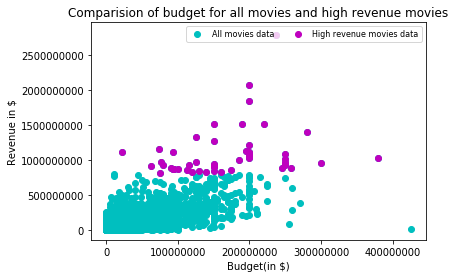

In [167]:
top50_movies_properties_chart('budget', 'Budget(in $)', 'Comparision of budget for all movies and high revenue movies')

#### Scatter plot : Votes vs Revenue

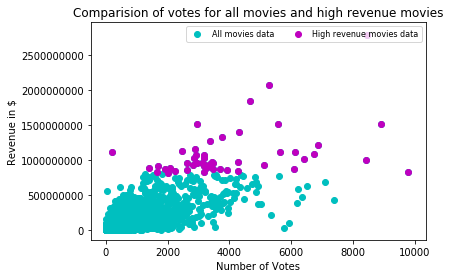

In [168]:
top50_movies_properties_chart('vote_count', 'Number of Votes', 'Comparision of votes for all movies and \
high revenue movies')

#### Scatter plot : Ratings vs Revenue

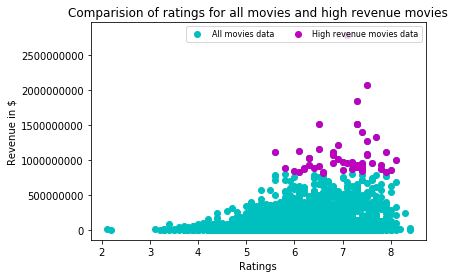

In [169]:
top50_movies_properties_chart('vote_average', 'Ratings', 'Comparision of ratings for all movies and \
high revenue movies')

#### Scatter plot : Runtime vs Revenue

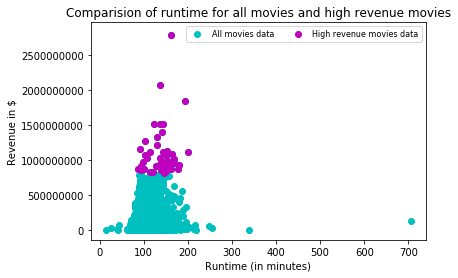

In [170]:
top50_movies_properties_chart('runtime', 'Runtime (in minutes)', 'Comparision of runtime for all movies and \
high revenue movies')

#### Scatter plot : Release year vs Revenue

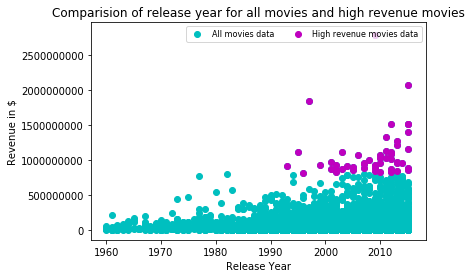

In [171]:
top50_movies_properties_chart('release_year', 'Release Year', 'Comparision of release year for \
all movies and high revenue movies')

#### Observation 1 for numerical features

- From this descriptive statistics, we can notice following outcomes :(for high revenue movies)
    - Average budget : \$168 million. 
    - Vote count average : ~4000 
    - Mean for vote_average/rating : ~7 (out of 10).
    - Runtime average : ~140
- By looking at the graphs, we can observe following : (for high revenue movies)

    - Budget vs revenue : Budget ranges from \$100 million to \$250 million 
    - Votes vs revenue : Vote count ranges from 2000 to 5000
    - Ratings vs revenue : Ratings ranges from 6 to 8
    - Runtime vs revenue : Runtime(in minutes) ranges from 100 to 200
    - Release year vs revenue : Most of the movies has been released between 2000 to 2015

#### Analysis of categorical feature

- As i states earlier, i will explore genre feature in this section to check whether high revenue movies has some common genre or not.
- Here, I am using function <a href="#egw">extract_genres_with_moviesInIt</a> to extract genres with number of movies in each genre for analyzing.
- Then, plotting *genre vs no. of movies in genre* graph using function <a href="#pma">plot_movies_attrs</a> for better visualization.

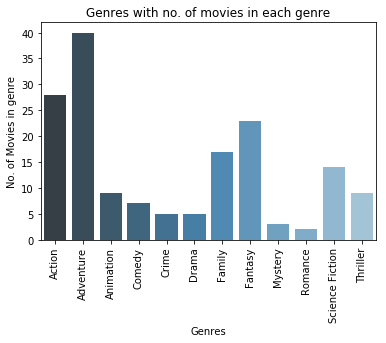

In [172]:
#re-initializing genre dictionary
genre_count = dict()

#extracting genres with number of movies using helper function extract_genres_with_moviesInIt()
top_genres_df = extract_genres_with_moviesInIt(top50_movies_by_revenue['genres'])

#extracting genre names from genre dataframe
genre_names = top_genres_df.index.values.tolist() 

#plotting 'genre vs no. of movie in it' graph using helper function plot_movies_attrs()
plot_movies_attrs(top_genres_df, 0, genre_names, 'Genres', 'No. of Movies in genre',
                 'Genres with no. of movies in each genre')

#### Observation 2 for categorical feature

- From the above graph, we can see that out of 50 movies, 80% movies(40 movies) are made in 'Adventure' genre. So, we can say that most of the high revenue movies have common genre 'Adventure'. 
- Also, only 2-3 high revenue movies have 'Romance' as genre.
- However, these are purely correlation and not to be inferred as causation.

<a id='conclusions'></a>
## Conclusions

### Limitations


There were several limitations of this analysis based on the given dataset.

- There were total of only 10866 rows, out of which 6000 rows had revenue values missing! Though, I could have fill those missing values by standard practices, revenues are major part of my analysis. So, i just removed records with missing values which resulted in dataset of 4850 rows only.
- Also, out of total 21 columns, 6 columns are irrelavant for analysis. Thus, i were left with only 15 columns. Since the data was obviously limited , adding other columns such as the movie's category and in how many countries movie was released, would be rather useful.
- All findings are limited to datset only.
- I have restricted myself to only given values of revenues. Any variances in currencies, like dollars, rupees, yen, etc. are not considered.
- It is not stated that, Whether all revenue sources are considered or not for counting total revenue.
- To find properties of high revenue movies, i have only considered top 50 highest grossing movies by revenue, on the assumption that they will provide enough information to draw out some pattern. Also, I have not accounted for *top movies by revenues adjusted for inflation*.

- This analysis is undergone despite its limitations. And it does its best to find patterns/trends among data.


### To conclude

- We filtered data for top 10 highest grossing movies by their original revenue. All movies in this list, had revenue above $1 billion and most of the movies in this list were released after 2008.
- Also, we got list of top 10 highest grossing movies by adjusted revenue for inflation. Only 4 movies from previous list were able to made it to this new list, because adjusted revenues for some old movies were higher.
- We found the common genres like 'Drama', 'Comedy', in which directors preferred to make movies.
- Some of the **tentative properties** of high revenue movies are :
    - Budget ranges from \$100 million to \$250 million. 
    - Vote count ranges from 2000 to 5000.
    - Ratings ranges from 6 to 8.
    - Runtime(in minutes) ranges from 100 to 200.
    - Most of the movies has been released between 2000 to 2015.
    - Common genre : 'Adventure'